# Aim

Attempting to implement the Support Vector Kalman method, as described at http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.672.2696&rep=rep1&type=pdf.


In [1]:
from sklearn import svm
import numpy as np
from aberrations import make_vibe_params, make_vibe_data, make_noisy_data, measurement_noise, f_1
from observer import make_kfilter, vibe_fit_freq, get_psd, predict, update
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from aberrations import time_id, f_sampling, f_1, times
W = int(f_sampling/f_1 * 2) # do I really understand how Nyquist works?
N = 3
#time_id /= 2 # half of it in regular KF time, half in SVK mode
steps = int(f_sampling * time_id)
times = np.arange(0, time_id, 1 / f_sampling)

In [3]:
# set up state training data
vib_freqs, vib_amps, vib_phase, vib_damping = make_vibe_params(N)
truth_states = np.array([make_vibe_data((vib_freqs[i:i+1], vib_amps[i:i+1], vib_phase[i:i+1], vib_damping[i:i+1])) 
                  for i in range(N)])[:,:steps]
truth = make_vibe_data((vib_freqs, vib_amps, vib_phase, vib_damping))[:steps]
noise = np.random.normal(0, measurement_noise, (N, times.size))
noisy_states = truth_states + noise
measurements = truth + np.sum(noise, axis=0)

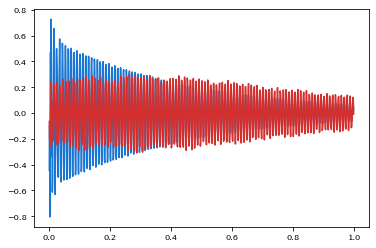

In [4]:
# first, let's run the Kalman filter for half a second normally
state, A, P, Q, H, R = make_kfilter(*vibe_fit_freq(get_psd(measurements[:steps]), N=N))
states_r = np.zeros((steps, state.size))
for k in range(steps):
    state, P = update(H, P, R, state, measurements[k])
    states_r[k] = state
    state, P = predict(A, P, Q, state)

plt.plot(times, truth)
plt.plot(times, [H.dot(state) for state in states_r])
plt.show()

In [5]:
# now, for the next half-second, we're going to use SVR
x_training = states_r[steps-W-2:steps-1] # a row is the state at a specific timestep
y_training = states_r[steps-W-1:steps].T # a row is a state variable over the W+1 timesteps

svk = svm.SVR(gamma='scale', C=1.0, epsilon=0) # to be edited!
for i in range(2*N):
    # help out the SVK by telling it the only state elements that matter
    # we know this is the case because we ran in frequency mode for half a second
    if i % 2 == 0:
        # we are at a position state variable
        print("\nposition ", i//2 + 1)
        x_training_i = x_training[:,i:i+2]
    else:
        # we are at a velocity state variable
        print("\nvelocity ", i//2 + 1)
        x_training_i = x_training[:,i-1:i+1]
    print("Actual        ", y_training[i][0])
    svk.fit(x_training_i, y_training[i])
    print("SVM prediction", svk.predict(x_training_i[0].reshape(1, -1))[0])


position  1
Actual         0.008432389538385066
SVM prediction 0.0722981640025504

velocity  1
Actual         95.22133824206809
SVM prediction 25.062595098243687

position  2
Actual         0.01127714929318637
SVM prediction 0.0018024944546803088

velocity  2
Actual         22.617693916967873
SVM prediction -2.344891422043489

position  3
Actual         -0.0018594001621251488
SVM prediction -0.0031509761602347298

velocity  3
Actual         -4.508184216131559
SVM prediction -2.932726962267988
